In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal

%matplotlib inline
imginfo = lambda img: print(type(img), img.dtype, img.shape)

mat = scipy.io.loadmat('data/data_rfa_forPython.mat')
sessions = mat["data_cfa"][0]

Length of time array: 4500 steps, around 1000 steps per second.

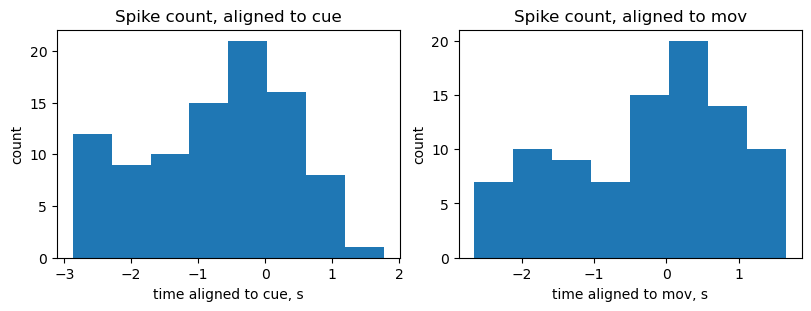

In [2]:
session_id = 0
trial_id = 0
neuron_id = 2

time = sessions[session_id]['time'][0]
cue = sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:, 0] - 1 # indices begin from 1!
mov = sessions[session_id]['trials'][trial_id, 0]['spikes_mov'][neuron_id, 0][:, 0] - 1

plot_align = True
if plot_align:
    fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(8,3))
    
    axs[0].set_title('Spike count, aligned to cue')
    axs[0].hist(time[cue], bins=8)
    axs[0].set_xlabel('time aligned to cue, s',  fontsize=10)
    axs[0].set_ylabel('count',  fontsize=10)
    
    axs[1].set_title('Spike count, aligned to mov')
    axs[1].hist(time[mov], bins=8)
    axs[1].set_xlabel('time aligned to mov, s',  fontsize=10)
    axs[1].set_ylabel('count',  fontsize=10)

## Smoothing

time series:
<class 'numpy.ndarray'> float64 (4885,)
window:
<class 'numpy.ndarray'> float64 (1000,)


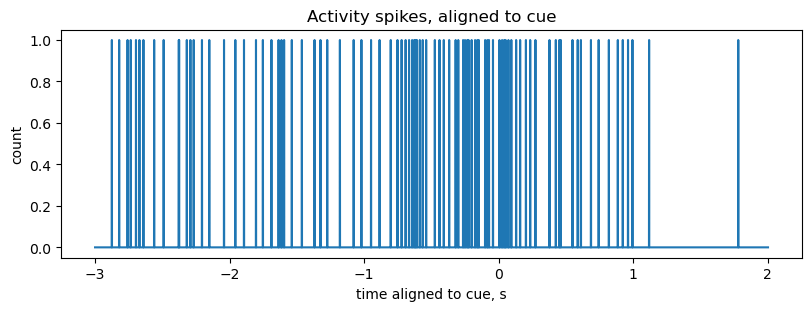

In [3]:
# Convert spike indices to explicit signal. For each time step 0 or 1
sig = np.zeros_like(time)
sig[cue] = 1

print("time series:")
imginfo(sig)

std = 1000 / 6 # rule of 3 sigma
win = signal.windows.gaussian(1000, std)

print("window:")
imginfo(win)

filtered = signal.convolve(sig, win, mode='same') / sum(win)

plot_smoothing = True
if plot_smoothing:
    fig, axs = plt.subplots(1, 1, layout='constrained', figsize=(8,3))
    axs.set_title('Activity spikes, aligned to cue')
    axs.plot(time, sig)
    #axs.plot(time, win)
    #axs.plot(time, filtered)
    #axs.plot(time[1000:2000], sig[1000:2000])
    axs.set_xlabel('time aligned to cue, s',  fontsize=10)
    axs.set_ylabel('count',  fontsize=10)
    #fig.savefig("spikes.png")

session: 0 neuron: 2


interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=251), Output()), _do…

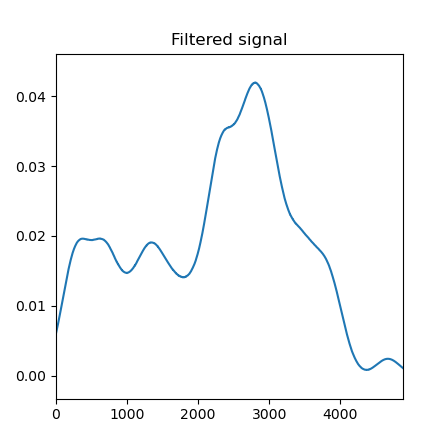

In [4]:
%matplotlib widget
from ipywidgets import widgets, Layout, interact

session_id = 0
trial_id = 0
neuron_id = 2

print("session:", session_id, "neuron:", neuron_id)

def update(w: int):
    print(w)

    trial_id = w
    
    time = sessions[session_id]['time'][0]
    cue = sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:, 0] - 1 # indices begin from 1!
    mov = sessions[session_id]['trials'][trial_id, 0]['spikes_mov'][neuron_id, 0][:, 0] - 1

    # === Convert spike indices to explicit signal. For each time step 0 or 1
    sig = np.zeros_like(time)
    sig[cue] = 1
    win_size = 1000
    std = win_size / 6 # rule of 3 sigma
    win = signal.windows.gaussian(win_size, std)
    filtered = signal.convolve(sig, win, mode='same') / sum(win)

    ax.clear()
    ax.plot(filtered)
    ax.set_title('Filtered signal')
    ax.margins(0, 0.1)
    
    # ax.set_title('Spike count, aligned to cue')
    # line = ax.hist(time[cue], bins=3)
    # ax.set_xlabel('time aligned to cue, s',  fontsize=10)
    # ax.set_ylabel('count',  fontsize=10)
    # ax.set_xlim((-3, 2))
    
    #fig.canvas.draw_idle()

image_width, image_height = 448, 448
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
ax.set_axis_off()

slider_w = widgets.IntSlider(
    min=0, max=len(sessions[session_id]['trials'])-1, step=1, value=0, layout=Layout(width="70%")
)
interact(update, w=slider_w)
pass

## Ditribution for time regions

In [5]:
session_id = 0
trial_id = 165
neuron_id = 2

time = sessions[session_id]['time'][0]
cue = sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:, 0] - 1 # indices begin from 1!
mov = sessions[session_id]['trials'][trial_id, 0]['spikes_mov'][neuron_id, 0][:, 0] - 1

In [6]:
n_steps = len(time)
print(n_steps)

# region 1, region 2, region 3
p1 = n_steps / 3
p2 = n_steps / 3 * 2
count = [np.sum(cue < p1), np.sum((p1 < cue) & (cue < p2)), np.sum(p2 < cue)] # for region 1, region 2, region 3
print(count)

4885
[24, 36, 2]


In [7]:
trial_num = len(sessions[session_id]['trials'])
n_regions = 6
all_count = np.zeros((trial_num, n_regions))

for trial_id in range(trial_num):
    cue = sessions[session_id]['trials'][trial_id, 0]['spikes_cue'][neuron_id, 0][:, 0] - 1 # indices begin from 1!

    for i in range(n_regions):
        p1 = n_steps / n_regions * i
        p2 = n_steps / n_regions * (i + 1)
        all_count[trial_id, i] = np.sum((p1 < cue) & (cue < p2))

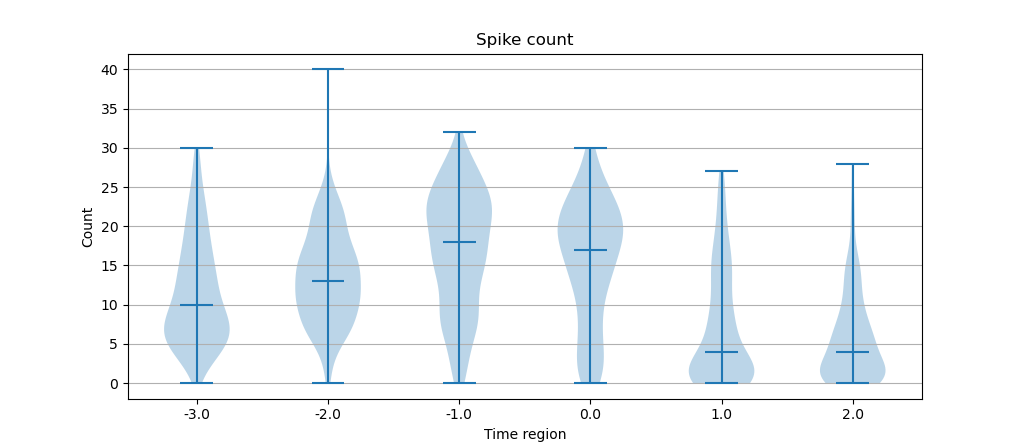

In [8]:
image_width, image_height = 1024, 448
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)

region_time = np.linspace(-3, 2, n_regions)

# plot violin plot
ax.violinplot(all_count,
                  showmeans=False,
                  showmedians=True)
ax.set_title('Spike count')
ax.set_xticks(np.arange(1, n_regions+1), labels=region_time)
ax.yaxis.grid(True)
ax.set_xlabel('Time region')
ax.set_ylabel('Count')
pass

## Averaging in high resolution

In [9]:
cue_or_mov = "spikes_cue"

def smooth_trials(session_id, neuron_id):
    """
    Apply filter on binary spike signal for each trial.
    Return: (trial_num, n_steps)
    """
    
    time = sessions[session_id]['time'][0] # doesn't depend on trial
    n_steps = len(time)
    
    trial_num = len(sessions[session_id]['trials'])
    
    # === histogram
    #n_regions = 6
    #all_count = np.zeros((trial_num, n_regions))
    
    highres = np.zeros((trial_num, n_steps)) # highres filter equivalent to histogram with box filter
    
    for trial_id in range(trial_num):
        shape = sessions[session_id]['trials'][trial_id, 0][cue_or_mov][neuron_id, 0].shape
        if shape[1] == 0:
            # !!! no spikes present. The result array already contains all zeros
            continue
            
        cue = sessions[session_id]['trials'][trial_id, 0][cue_or_mov][neuron_id, 0][:, 0] - 1 # indices begin from 1!
    
        # === Convert spike indices to continuous signal
        sig = np.zeros_like(time)
        sig[cue] = 1

        # gaussian filtering
        win_size = 2000
        std = win_size / 6 # rule of 3 sigma
        win = signal.windows.gaussian(win_size, std)
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        highres[trial_id, :] = filtered
    
        # === histogram
        # for i in range(n_regions):
        #     p1 = n_steps / n_regions * i
        #     p2 = n_steps / n_regions * (i + 1)
        #     all_count[trial_id, i] = np.sum((p1 < cue) & (cue < p2))

    return highres

session_id = 0
neuron_id = 4
smooth_trials(session_id, neuron_id).shape

(252, 4885)

In [10]:
def get_outcome(sessions, session_id):
    """
    reaction_time, shape (trial_num): time from cue to release, or equal to press_to_release
    if the mouse didn't wait for the cue
    outcome, shape (trial_num): 0 if early, 1 if correct, 2 if late
    """
    total_trials = len(sessions[session_id]['trials'])
    outcome = np.zeros((total_trials), dtype=int) # 0 - early, 1 - correct, 2 - late
    reaction_time = np.zeros((total_trials))
    press_to_release = np.zeros((total_trials))

    # convert RT and press_to_release from matlab to numpy
    for trial_id in range(len(sessions[session_id]['trials'])):
        reaction_time[trial_id] = sessions[session_id]['trials'][trial_id, 0]['RT'][0, 0]
        press_to_release[trial_id] = sessions[session_id]['trials'][trial_id, 0]['press_to_release'][0, 0]

    # calculate if release was early, correct or later
    equal = np.isclose(press_to_release, reaction_time)
    outcome[equal] = 0
    outcome[~equal & (reaction_time < 1.0)] = 1
    outcome[~equal & (reaction_time > 1.0)] = 2

    return reaction_time, outcome

session 0


interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=10), Output()), _dom…

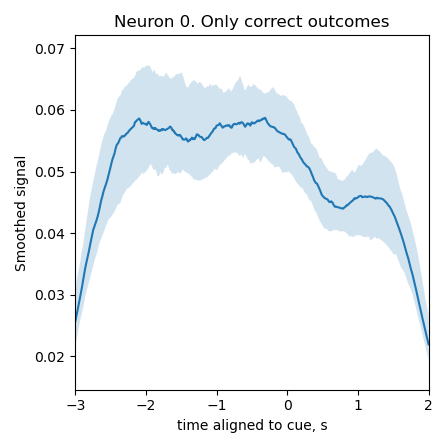

In [11]:
%matplotlib widget
from ipywidgets import widgets, Layout, interact

session_id = 0
print("session", session_id)

def update(w: int):
    print(w)

    neuron_id = w
    trials = smooth_trials(session_id, neuron_id) # (trial_num, n_steps)
    x = sessions[session_id]['time'][0] # doesn't depend on trial

    # select only correct outcomes
    RT, outcome = get_outcome(sessions, session_id)
    #trials = trials[(outcome == 0) & (RT < 0.5)]
    trials = trials[outcome != 0]
    
    median = np.median(trials, axis=0)
    quantile_1_4 = np.quantile(trials, 0.25, axis=0)
    quantile_3_4 = np.quantile(trials, 0.75, axis=0)
    
    ax.clear()
    ax.plot(x, median)
    ax.fill_between(x, quantile_1_4, quantile_3_4, alpha=0.2)
    ax.set_title('Neuron ' + str(neuron_id) + ". Only correct outcomes")
    ax.set_xlabel('time aligned to cue, s',  fontsize=10)
    ax.set_ylabel('Smoothed signal',  fontsize=10)
    ax.set_xlim((-3, 2))
    ax.margins(0, 0.1)

    fig.tight_layout()
    fig.canvas.draw_idle()

image_width, image_height = 448, 448
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)

ax.set_axis_off()

fake_trial_id = 0
n_neurons = len(sessions[session_id]['trials'][fake_trial_id, 0][cue_or_mov])
slider_w = widgets.IntSlider(
    min=0, max=n_neurons-1, step=1, value=0, layout=Layout(width="70%")
)
interact(update, w=slider_w)
pass